Exploring models and then using a train test split

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression



**Exploring models**

In [2]:
# Remove identifiers and non-feature columns. Right now only worrying about VOCs, not demographics yet.
df_main = pd.read_csv("df_main_normalized.csv")

y = df_main["TB Status"]  # Target
X = df_main.drop(columns=["PID", "TB Status", "Age", "BMI", "HIV Status"])  # Features without demographics for now

In [3]:
# QC Checks
print(np.isnan(X).sum().sum())
print(np.isinf(X).sum().sum())
# print(X.describe())
print((X.std() == 0).sum())  # Number of zero-variance features

0
0
0


Above sets up the data and removes the target from the features.

The next cell below is to figure out what number of features is appropriate for SVM-RFE.

In [4]:
# I trust my model and the ROC-AUC is stable so I'm going to supress some warnings for a cleaner output
import warnings
warnings.filterwarnings("ignore", message=".*invalid value encountered in matmul.*")
warnings.filterwarnings("ignore", message=".*divide by zero encountered in matmul.*")
warnings.filterwarnings("ignore", message=".*overflow encountered in matmul.*")

****SVM-RFE SECTION****

5 features → ROC-AUC: 0.770
10 features → ROC-AUC: 0.766
15 features → ROC-AUC: 0.786
20 features → ROC-AUC: 0.756
25 features → ROC-AUC: 0.738
30 features → ROC-AUC: 0.747
35 features → ROC-AUC: 0.756
40 features → ROC-AUC: 0.756


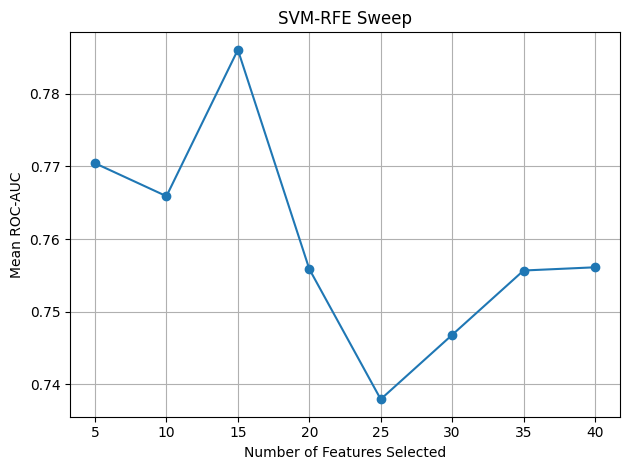

In [5]:
# Config
svc = LinearSVC(C=1, max_iter=10000)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
feature_counts = list(range(5, min(41, X.shape[1]), 5))
scores = []

# Sweep
for n in feature_counts:
    pipeline = Pipeline([
        ("feature_selection", RFE(estimator=svc, n_features_to_select=n)),
        ("classifier", svc)
    ])
    score = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc').mean()
    scores.append(score)
    print(f"{n} features → ROC-AUC: {score:.3f}")

# Plot
plt.plot(feature_counts, scores, marker='o')
plt.xlabel("Number of Features Selected")
plt.ylabel("Mean ROC-AUC")
plt.title("SVM-RFE Sweep")
plt.grid(True)
plt.tight_layout()
plt.show()

**Note to Self** I'm getting a ton of runtime warnings related to divide by zero encoutered. I'm guessing this is due to zero variance in some columns maybe? Everything normalized well so I dont think it's a skew issue. Going to try to run a variance filter.

Tried the variance filter. it didn't drop anything so these errors are something else...



Based off of the ROC-AUC, we are selecting 5 features. 15 does show better mean ROC, but looking for a simpler model

In [12]:
svm = svc = LinearSVC(C=1, max_iter=10000)  # going with C=1 for now to avoid overfitting

# select top 5
rfe = RFE(estimator=svm, n_features_to_select=5, step=1)

# Fit RFE model
rfe.fit(X, y)

RFE(estimator=LinearSVC(C=1, max_iter=10000), n_features_to_select=5)

In [13]:
selected_features = X.columns[rfe.support_]
print("Selected features:", selected_features.tolist())

# Rankings (1 = selected)
ranking = pd.Series(rfe.ranking_, index=X.columns).sort_values()
print("Top 20 ranked features:")
print(ranking.head(20))

Selected features: ['001640-89-7_group2', '001762-27-2_group1', '019549-87-2_group1', '1000132-10-9_group2', '1000401-12-0_group1']
Top 20 ranked features:
001640-89-7_group2      1
019549-87-2_group1      1
001762-27-2_group1      1
1000401-12-0_group1     1
1000132-10-9_group2     1
054446-78-5_group1      2
000115-11-7_group2      3
001203-17-4_group1      4
000098-83-9_group2      5
000141-78-6_group2      6
000100-41-4_group4      7
000496-11-7_group2      8
095798-15-5_group1      9
001122-82-3_group1     10
000095-16-9_group2     11
000110-98-5_group1     12
000589-34-4_group2     13
027750-45-4_group1     14
003387-41-5_group1     15
001074-55-1_group2     16
dtype: int64


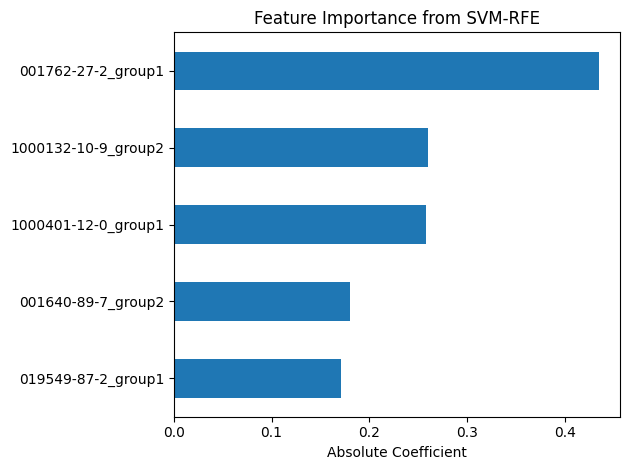

In [14]:
# Visualizing
# Refit SVM just on selected features for coefficient extraction
svm.fit(X[selected_features], y)
coefs = pd.Series(np.abs(svm.coef_[0]), index=selected_features)

# Plot
coefs.sort_values().plot(kind='barh')
plt.title("Feature Importance from SVM-RFE")
plt.xlabel("Absolute Coefficient")
plt.tight_layout()
plt.show()

**Note to self** this makes me wonder if I should cut off the bottom 3 or 4? Make a more simple model? 

In [15]:
# Cross-validate
# Needing this LinearSVC and not just linear. The data is fine but it's breaking. Probably too many features for low number of samples?
# LinearSVC has a better solver for higher dimensions.
pipeline = Pipeline([
    ("feature_selection", RFE(LinearSVC(C=1, max_iter=10000), n_features_to_select=5)),
    ("svm", LinearSVC(C=1, max_iter=10000))
])

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds seems standard by literature. Random state of 42 similar to above.
scores = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc")

print(f"Mean ROC-AUC: {scores.mean():.4f} ± {scores.std():.4f}")

Mean ROC-AUC: 0.7704 ± 0.0496


****LASSO****

In [15]:
# Resetting warnings for now
# warnings.resetwarnings()

In [16]:
# LASSO with l1
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.10, max_iter=10000)  # A lower C means fewer features (0.5, 0.1)

# CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipeline = Pipeline([
    ('lasso', lasso)
])

scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')
print(f"Mean ROC-AUC: {scores.mean():.4f} ± {scores.std():.4f}")

Mean ROC-AUC: 0.8621 ± 0.0501


**NOTE** These errors are the same reason as with SVM-RFE, that the dim of the data is very high while the n_sample count isn't super large as well.


LASSO-selected features with odds ratios:
                     Log-Odds Coef  Odds Ratio
001640-89-7_group2        0.113450    1.120136
000115-11-7_group2        0.085030    1.088750
000110-98-5_group1        0.029126    1.029554
000095-16-9_group2        0.010946    1.011006
001122-82-3_group1       -0.006519    0.993503
000110-54-3_group2       -0.008674    0.991363
001074-43-7_group1       -0.009491    0.990554
000108-67-8_group3       -0.021254    0.978971
063521-76-6_group3       -0.027416    0.972957
000620-14-4_group1       -0.039950    0.960838
038165-93-4_group1       -0.040390    0.960415
000109-52-4_group1       -0.096313    0.908180
054446-78-5_group1       -0.139984    0.869372
000098-86-2_group2       -0.145314    0.864751
019549-87-2_group1       -0.162772    0.849785
1000132-10-9_group2      -0.223771    0.799498
1000401-12-0_group1      -0.266461    0.766086
000074-97-5_group1       -0.285893    0.751343
001762-27-2_group1       -0.678315    0.507471


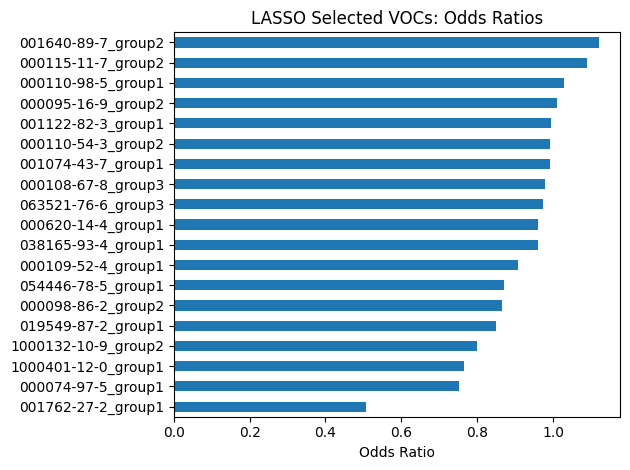

In [18]:
# Fit on full dataset
lasso.fit(X, y)

# coefficients and odds ratios
coefs = pd.Series(lasso.coef_[0], index=X.columns)
nonzero_coefs = coefs[coefs != 0]
odds_ratios = np.exp(nonzero_coefs)

# Combine into a df for report
summary_df = pd.DataFrame({
    "Log-Odds Coef": nonzero_coefs,
    "Odds Ratio": odds_ratios
}).sort_values("Odds Ratio", ascending=False)

print("\nLASSO-selected features with odds ratios:")
print(summary_df)

# visualize odds ratios
summary_df["Odds Ratio"].sort_values().plot(kind='barh')
plt.title("LASSO Selected VOCs: Odds Ratios")
plt.xlabel("Odds Ratio")
plt.tight_layout()
plt.show()

So, LASSO chose 19 features and all but one are negative predictors with one being a positive predictor.

Was there overlap with LASSO's selection and SVM-RFE?
YES!
* SVM-RFE's 5 chosen were:
    * 001640-89-7_group2
    * 019549-87-2_group1
    * 001762-27-2_group1
    * 1000401-12-0_group1
    * 1000132-10-9_group2

* LASSO's that matched were:
    * 001640-89-7_group2        0.113450    1.120136
    * 019549-87-2_group1       -0.162772    0.849785
    * 001762-27-2_group1       -0.678315    0.507471
    * 1000401-12-0_group1      -0.266461    0.766086
    * 1000132-10-9_group2      -0.223771    0.799498

This similiarity makes sense, as these are, ideally, impactful predictors.

****LASSO Based On SVM-RFE Features****

Mean ROC-AUC (LASSO on SVM-RFE): 0.8876 ± 0.0256

LASSO-on-RFE selected features with odds ratios:
                     Log-Odds Coef  Odds Ratio
001640-89-7_group2        0.139456    1.149648
019549-87-2_group1       -0.197946    0.820414
1000132-10-9_group2      -0.375743    0.686779
1000401-12-0_group1      -0.413978    0.661015
001762-27-2_group1       -0.902225    0.405666


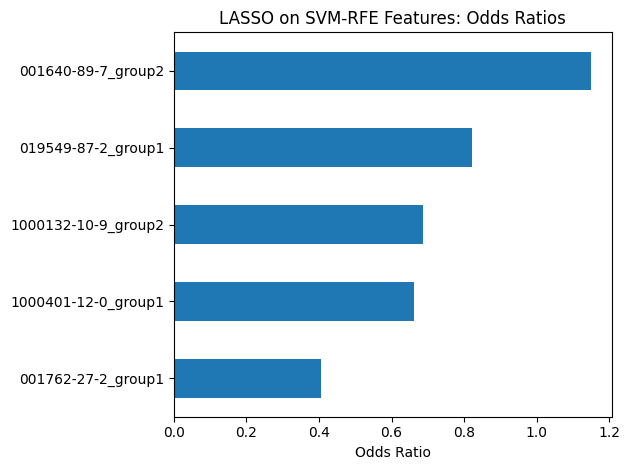

In [19]:
# SVM-RFE selected features:

selected_features = [
    '001640-89-7_group2',
    '019549-87-2_group1',
    '001762-27-2_group1',
    '1000401-12-0_group1',
    '1000132-10-9_group2',]


X_sub = df_main[selected_features]
y = df_main["TB Status"]  # this hasn't changed

lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=10000)  # same penalty as previous LASSO

# CV performance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lasso, X_sub, y, cv=cv, scoring="roc_auc")
print(f"Mean ROC-AUC (LASSO on SVM-RFE): {scores.mean():.4f} ± {scores.std():.4f}")

# Fit final model
lasso.fit(X_sub, y)

# coefficients and odds ratios
coefs = pd.Series(lasso.coef_[0], index=X_sub.columns)
nonzero_coefs = coefs[coefs != 0]
odds_ratios = np.exp(nonzero_coefs)

# report
summary_df = pd.DataFrame({
    "Log-Odds Coef": nonzero_coefs,
    "Odds Ratio": odds_ratios
}).sort_values("Odds Ratio", ascending=False)

print("\nLASSO-on-RFE selected features with odds ratios:")
print(summary_df)

# Visualize
summary_df["Odds Ratio"].sort_values().plot(kind='barh')
plt.title("LASSO on SVM-RFE Features: Odds Ratios")
plt.xlabel("Odds Ratio")
plt.tight_layout()
plt.show()

**TODO** 

Now that model exploration is completed...
* time to use a test split
